In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from playsound import playsound

from scipy.spatial import cKDTree

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


## Ensemble corrected computed from bias corrected RSR products, code 2_bias_coorection.ipynb

In [ ]:
correction, nameout = 'quantile-quantile', 'QQc'
# correction, nameout = 'linear-regression', 'LRc'

print(f'Correction method: {correction}')

In [2]:
REFERENCE = 'CHIRPS' # grid reference
SATELLITES = 'ALL' 

yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

npix = 2
acf = 'mar'
cor = 'pearson'

lon_min, lon_max, lat_min, lat_max, area, toll = 6.5, 19, 36.5, 48, 'ITALY', 0.002
Tr = [5,  10,  20,  50, 100, 200]

In [3]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected')
dir_out = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','6_DOWN_BCorrected')

In [5]:
# CMORPH data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_CM = xr.open_dataset(data_dir)
time_year = DATA_CM.year.values
del DATA_CM

In [6]:
def get_nearest_values(ref_lat2d, ref_lon2d, target_lat2d, target_lon2d, target_data):
    """
    Para cada punto en la malla de referencia, busca el valor más cercano en la malla objetivo.
    """
    ny, nx = ref_lat2d.shape
    ref_points = np.column_stack((ref_lat2d.ravel(), ref_lon2d.ravel()))
    target_points = np.column_stack((target_lat2d.ravel(), target_lon2d.ravel()))
    tree = cKDTree(target_points)
    _, idx = tree.query(ref_points)
    matched_values = target_data.ravel()[idx]
    return matched_values.reshape(ny, nx)

def Create_Ensemble(REFERENCE, PARAM, SATELLITES='ALL'):
    '''
    Create and Ensemble Product using CHIRPS grid
    ALL = ['CMORPH', 'ERA5', 'GSMaP', 'MSWEP', 'IMERG']
    NOGSMaP = ['CMORPH', 'ERA5', 'MSWEP', 'IMERG']
    '''

    data_dir = os.path.join(dir_base, f'ITALY_DOWN_{REFERENCE}_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
    DATA_REF = xr.open_dataset(data_dir)
    lons_REF, lats_REF = DATA_REF.lon.values, DATA_REF.lat.values
    lon2d_REF, lat2d_REF = np.meshgrid(lons_REF, lats_REF)

    if SATELLITES == 'ALL':

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT1 = xr.open_dataset(data_dir)
        lon2d_SAT1, lat2d_SAT1 = np.meshgrid(DATA_SAT1.lon.values, DATA_SAT1.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT2 = xr.open_dataset(data_dir)
        lon2d_SAT2, lat2d_SAT2 = np.meshgrid(DATA_SAT2.lon.values, DATA_SAT2.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        # data_dir = os.path.join(dir_base, f'ITALY_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_NoCorrection.nc')
        DATA_SAT3 = xr.open_dataset(data_dir)
        lon2d_SAT3, lat2d_SAT3 = np.meshgrid(DATA_SAT3.lon.values, DATA_SAT3.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT4 = xr.open_dataset(data_dir)
        lon2d_SAT4, lat2d_SAT4 = np.meshgrid(DATA_SAT4.lon.values, DATA_SAT4.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT5 = xr.open_dataset(data_dir)
        lon2d_SAT5, lat2d_SAT5 = np.meshgrid(DATA_SAT5.lon.values, DATA_SAT5.lat.values)

        DATA_SAT = [DATA_SAT1, DATA_SAT2, DATA_SAT3, DATA_SAT4, DATA_SAT5]
        LATLON_SAT = [
                    (lat2d_SAT1, lon2d_SAT1),
                    (lat2d_SAT2, lon2d_SAT2),
                    (lat2d_SAT3, lon2d_SAT3),
                    (lat2d_SAT4, lon2d_SAT4),
                    (lat2d_SAT5, lon2d_SAT5),]

    elif SATELLITES == 'NOGSMaP':

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT1 = xr.open_dataset(data_dir)
        lon2d_SAT1, lat2d_SAT1 = np.meshgrid(DATA_SAT1.lon.values, DATA_SAT1.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT2 = xr.open_dataset(data_dir)
        lon2d_SAT2, lat2d_SAT2 = np.meshgrid(DATA_SAT2.lon.values, DATA_SAT2.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT3 = xr.open_dataset(data_dir)
        lon2d_SAT3, lat2d_SAT3 = np.meshgrid(DATA_SAT3.lon.values, DATA_SAT3.lat.values)

        data_dir = os.path.join(dir_base, f'ITALY_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
        DATA_SAT4 = xr.open_dataset(data_dir)
        lon2d_SAT4, lat2d_SAT4 = np.meshgrid(DATA_SAT4.lon.values, DATA_SAT4.lat.values)
        
        DATA_SAT = [DATA_SAT1, DATA_SAT2, DATA_SAT3, DATA_SAT4]
        LATLON_SAT = [
                    (lat2d_SAT1, lon2d_SAT1),
                    (lat2d_SAT2, lon2d_SAT2),
                    (lat2d_SAT3, lon2d_SAT3),
                    (lat2d_SAT4, lon2d_SAT4),]

    else: 
        print('ERROR WITH SATELLITES GROUP')
        return 0

    # ==================================================================================================

    DATA_SAT = [ds.sel(year=DATA_REF.year) for ds in DATA_SAT] 
    ntimes = DATA_REF[PARAM].shape[0] 

    REFE_remap = np.full((ntimes, *lat2d_REF.shape), np.nan)
    SAT_remap = [np.full_like(REFE_remap, np.nan) for _ in range(len(DATA_SAT))]

    for i in range(ntimes):
        REFE = DATA_REF[PARAM].values[i, :, :]
        REFE_remap[i, :, :] = REFE

        for k, (DATA_k, (lat2d_k, lon2d_k)) in enumerate(zip(DATA_SAT, LATLON_SAT)):
            SAT_k = DATA_k[PARAM].values[i, :, :]

            SAT_near = get_nearest_values(lat2d_REF, lon2d_REF, lat2d_k, lon2d_k, SAT_k)

            SAT_remap[k][i, :, :] = SAT_near

    assert all(arr.shape == REFE_remap.shape for arr in SAT_remap)
    stacked_all = np.stack([REFE_remap] + SAT_remap,axis=0)

    # ==================================================================================================
    # Ensemble MEAN and MEDIAN
    Ensemble_mean   = np.nanmean(stacked_all, axis=0)
    Ensemble_median = np.nanmedian(stacked_all, axis=0)

    # Ensemble WEIGHTED
    p = stacked_all.shape[0]
    # 1) median reference (por tiempo o agregado) -> aquí por tiempo
    median = np.nanmedian(stacked_all, axis=0)
    # 2) compute mean absolute dev from median per product (avg over time)
    mad = np.nanmean(np.abs(stacked_all - median), axis=1)  # (p, ny, nx)
    # 3) inverse mad weights (higher weight = closer to median)
    inv_mad = 1.0 / (mad + 1e-6)
    w = inv_mad / np.nansum(inv_mad, axis=0)  # (p, ny, nx)
    # 4) weighted ensemble per time
    Ensemble_weighted = np.nansum(w[:, None, :, :] * stacked_all, axis=0)  # (nt, ny, nx)

    # Ensemble TRIMEAN
    Q25 = np.nanpercentile(stacked_all, 25, axis=0)
    Q50 = np.nanpercentile(stacked_all, 50, axis=0)
    Q75 = np.nanpercentile(stacked_all, 75, axis=0)
    Ensemble_trimean = (Q25 + 2*Q50 + Q75) / 4

    return Ensemble_mean, Ensemble_median, Ensemble_weighted, Ensemble_trimean, lons_REF, lats_REF

In [7]:
NYs_mean, NYs_median, NYs_weighted, NYs_trimean, lons_REF, lats_REF = Create_Ensemble(REFERENCE, 'NYs', SATELLITES)
CYs_mean, CYs_median, CYs_weighted, CYs_trimean, _, _ = Create_Ensemble(REFERENCE, 'CYs', SATELLITES)
WYs_mean, WYs_median, WYs_weighted, WYs_trimean, _, _ = Create_Ensemble(REFERENCE, 'WYs', SATELLITES)

NYd_mean, NYd_median, NYd_weighted, NYd_trimean, lons_REF, lats_REF = Create_Ensemble(REFERENCE, 'NYd', SATELLITES)
CYd_mean, CYd_median, CYd_weighted, CYd_trimean, _, _ = Create_Ensemble(REFERENCE, 'CYd', SATELLITES)
WYd_mean, WYd_median, WYd_weighted, WYd_trimean, _, _ = Create_Ensemble(REFERENCE, 'WYd', SATELLITES)

lon2d_REF, lat2d_REF = np.meshgrid(lons_REF, lats_REF)

In [8]:
# =======================================================
# Mean
ENSEMBLE_Mevs_mean = ART_down.pre_quantiles_array(
                        NYs_mean, 
                        CYs_mean, 
                        WYs_mean, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

ENSEMBLE_Mevd_mean = ART_down.pre_quantiles_array(
                        NYd_mean, 
                        CYd_mean, 
                        WYd_mean, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

# =======================================================
# Median
ENSEMBLE_Mevs_median = ART_down.pre_quantiles_array(
                        NYs_median, 
                        CYs_median, 
                        WYs_median, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

ENSEMBLE_Mevd_median = ART_down.pre_quantiles_array(
                        NYd_median, 
                        CYd_median, 
                        WYd_median, 
                        Tr, 
                        lats_REF, lons_REF,
                        1)

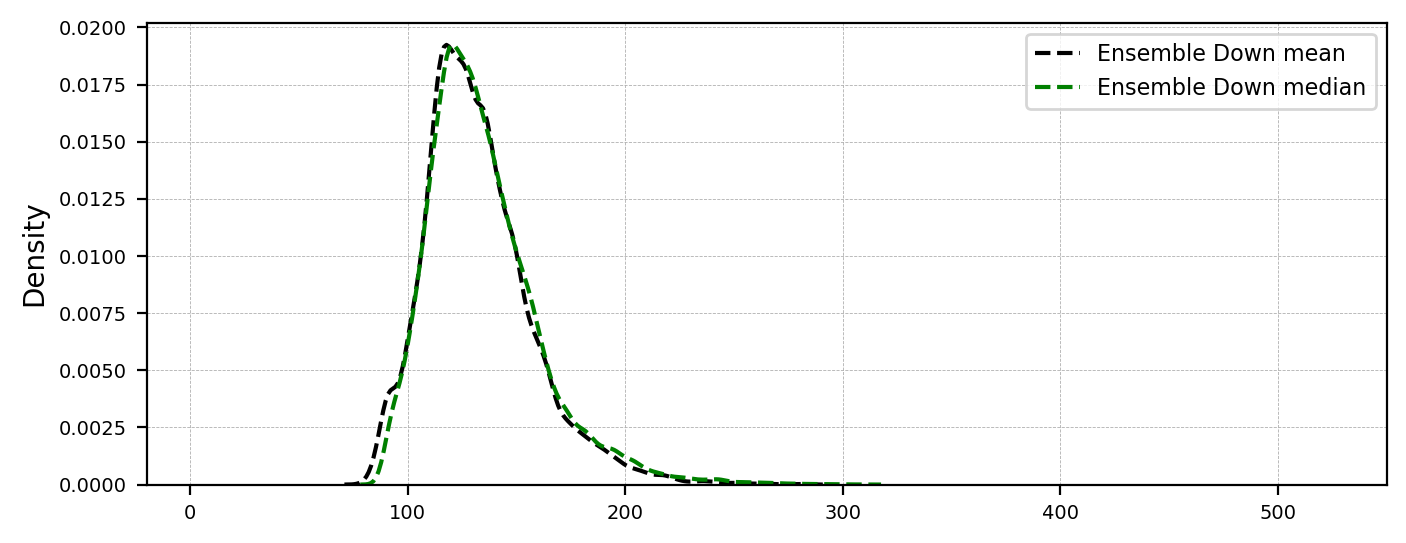

In [9]:
fig = plt.figure(figsize=(8,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(ENSEMBLE_Mevd_mean[3,:,:].flatten(),color='k',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Down mean')
sns.kdeplot(ENSEMBLE_Mevd_median[3,:,:].flatten(),color='g',linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'Ensemble Down median')

ax1.set_xlim(-20,550)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.legend(fontsize=8)

Text(0.0, 1.0, '(c) Mean diff')

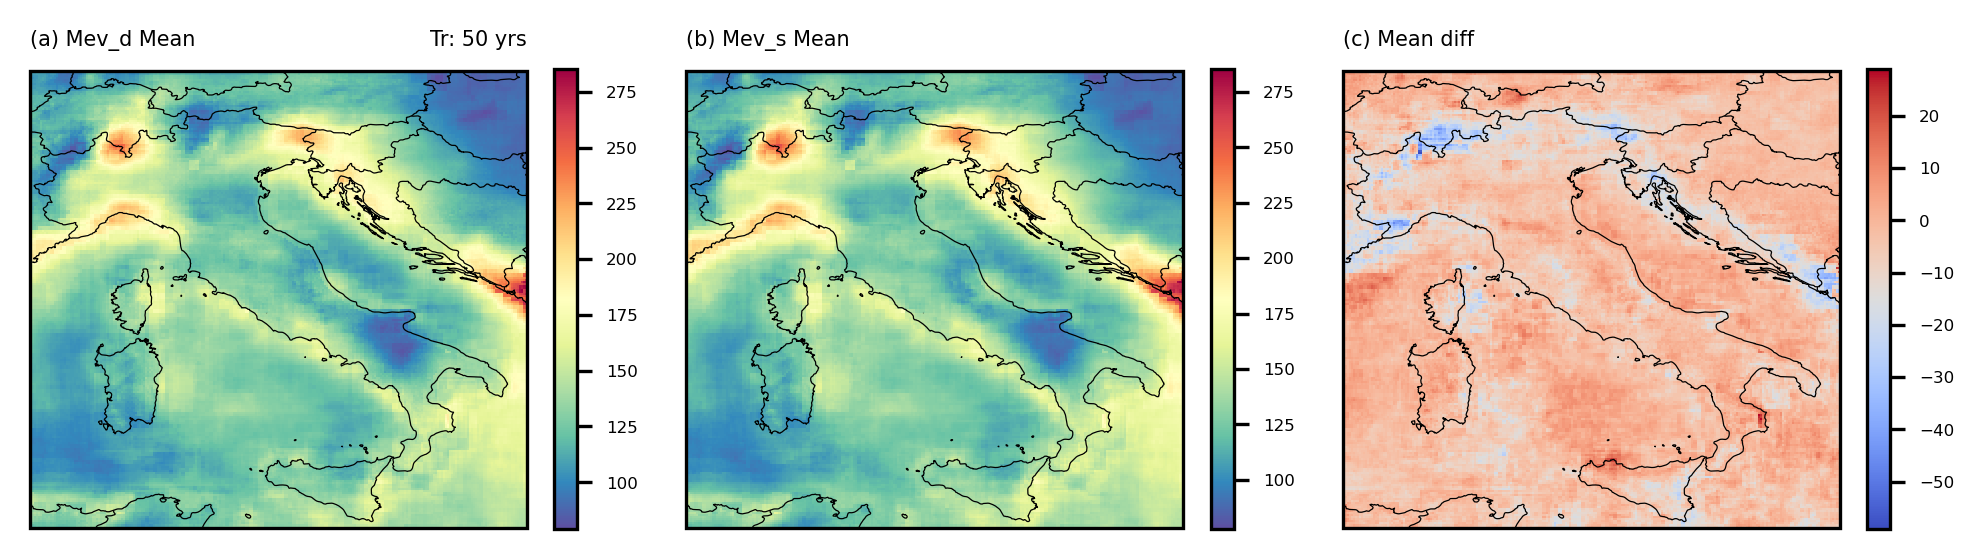

In [10]:
levels = np.arange(40, 210, 10)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_mean[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mev_d Mean', fontsize=5, loc='left')
ax1.set_title(f'Tr: 50 yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevs_mean[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Mev_s Mean', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_mean[3,:,:]-ENSEMBLE_Mevs_median[3,:,:], cmap='coolwarm', norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Mean diff', fontsize=5, loc='left')

Text(0.0, 1.0, '(c) Median Diff')

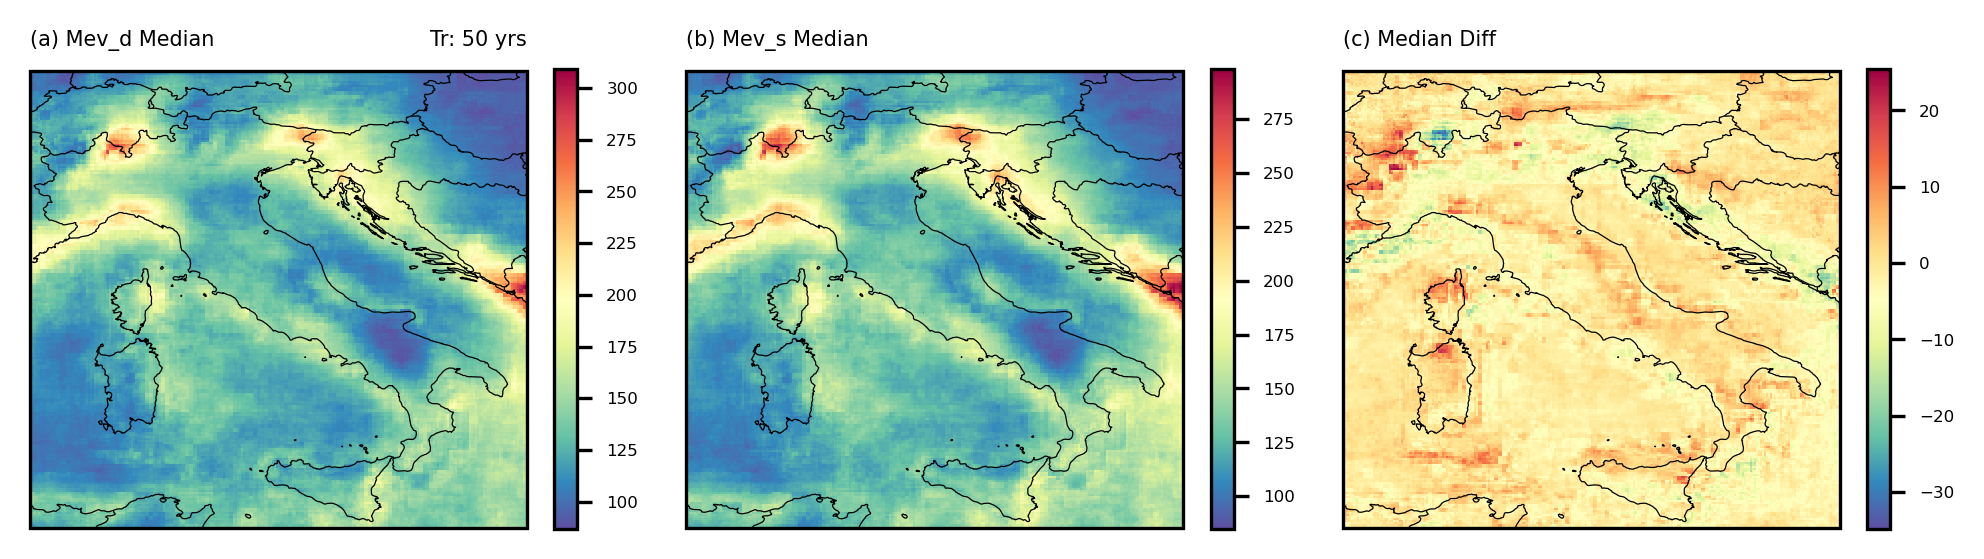

In [11]:
levels = np.arange(40, 210, 10)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_median[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mev_d Median', fontsize=5, loc='left')
ax1.set_title(f'Tr: 50 yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevs_median[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Mev_s Median', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.pcolormesh(lon2d_REF, lat2d_REF, ENSEMBLE_Mevd_median[3,:,:]-ENSEMBLE_Mevs_median[3,:,:], cmap=cmap, norm=norm)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Median Diff', fontsize=5, loc='left')

In [12]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_mean),
        "CYs": (("year","lat","lon"), CYs_mean),
        "WYs": (("year","lat","lon"), WYs_mean),
        "NYd": (("year","lat","lon"), NYd_mean),
        "CYd": (("year","lat","lon"), CYd_mean),
        "WYd": (("year","lat","lon"), WYd_mean),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mevs_mean),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mevd_mean),
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lats_REF, 
        'lon': lons_REF
    },
    attrs=dict(description=f"ENSEMBLE-mean of the Raw/downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid using mean",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Corrected Ensemble Raw Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Raw Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Corrected Ensemble Raw Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Raw Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Corrected Ensemble Raw Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Raw Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Corrected Ensemble Raw Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Raw Ext-Quant"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Corrected Ensemble Downscaled Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Corrected Ensemble Downscaled Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Corrected Ensemble Downscaled Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Corrected Ensemble Downscaled Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [13]:
PRE_out = os.path.join(os.path.join(dir_out, f'ITALY_ENSEMBLE_{SATELLITES}_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_mean.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_mean.nc


In [14]:
ENSEMBLE_xr = xr.Dataset(
    data_vars={
        "NYs": (("year","lat","lon"), NYs_median),
        "CYs": (("year","lat","lon"), CYs_median),
        "WYs": (("year","lat","lon"), WYs_median),
        "Mev_s": (("Tr","lat","lon"), ENSEMBLE_Mevs_median),
        "NYd": (("year","lat","lon"), NYd_median),
        "CYd": (("year","lat","lon"), CYd_median),
        "WYd": (("year","lat","lon"), WYd_median),
        "Mev_d": (("Tr","lat","lon"), ENSEMBLE_Mevd_median),
    },
    coords={
        'year': time_year, 
        'Tr': Tr, 
        'lat': lats_REF, 
        'lon': lons_REF
    },
    attrs=dict(description=f"ENSEMBLE of the Raw/downscaled precipitation data for {yy_s}-{yy_e} period using CHIRPS grid using median",)
)

ENSEMBLE_xr.NYs.attrs["units"] = "# days"
ENSEMBLE_xr.NYs.attrs["long_name"] = "Corrected Ensemble Raw Number of Wet Days"
ENSEMBLE_xr.NYs.attrs["origname"] = "Raw Wet Days"

ENSEMBLE_xr.CYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYs.attrs["long_name"] = "Corrected Ensemble Raw Scale Parameter"
ENSEMBLE_xr.CYs.attrs["origname"] = "Raw Scale"

ENSEMBLE_xr.WYs.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYs.attrs["long_name"] = "Corrected Ensemble Raw Shape Parameter"
ENSEMBLE_xr.WYs.attrs["origname"] = "Raw Shape"

ENSEMBLE_xr.Mev_s.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_s.attrs["long_name"] = "Corrected Ensemble Raw Extreme Quantiles"
ENSEMBLE_xr.Mev_s.attrs["origname"] = "Raw Ext-Quant"

ENSEMBLE_xr.NYd.attrs["units"] = "# days"
ENSEMBLE_xr.NYd.attrs["long_name"] = "Corrected Ensemble Downscaled Number of Wet Days"
ENSEMBLE_xr.NYd.attrs["origname"] = "Down Wet Days"

ENSEMBLE_xr.CYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.CYd.attrs["long_name"] = "Corrected Ensemble Downscaled Scale Parameter"
ENSEMBLE_xr.CYd.attrs["origname"] = "Down Scale"

ENSEMBLE_xr.WYd.attrs["units"] = "nondimensional"
ENSEMBLE_xr.WYd.attrs["long_name"] = "Corrected Ensemble Downscaled Shape Parameter"
ENSEMBLE_xr.WYd.attrs["origname"] = "Down Shape"

ENSEMBLE_xr.Mev_d.attrs["units"] = "mm/day"
ENSEMBLE_xr.Mev_d.attrs["long_name"] = "Corrected Ensemble Downscaled Extreme Quantiles"
ENSEMBLE_xr.Mev_d.attrs["origname"] = "Down Ext-Quant"

ENSEMBLE_xr.lat.attrs["units"] = "degrees_north"
ENSEMBLE_xr.lat.attrs["long_name"] = "Latitude"

ENSEMBLE_xr.lon.attrs["units"] = "degrees_east"
ENSEMBLE_xr.lon.attrs["long_name"] = "Longitude"

In [15]:
PRE_out = os.path.join(os.path.join(dir_out, f'ITALY_ENSEMBLE_{SATELLITES}_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_median.nc'))
print(f'Export PRE data to {PRE_out}')
ENSEMBLE_xr.to_netcdf(PRE_out)

Export PRE data to /media/arturo/T9/Data/Italy/Satellite/6_DOWN_BCorrected/ITALY_ENSEMBLE_ALL_1dy_2002_2023_npix_2_thr_1_acf_mar_genetic_pearson_median.nc


In [16]:
playsound("../sound/HOMER_DOH.mp3")